## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

1. Oczyść dane i zaprezentuj rozkład klas

In [2]:
import pandas as pd
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

c:\Users\Administrator\Desktop\-NLP-Stress-Identification\StressEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('Stress.csv')
data

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005
...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [5]:
cols_to_drop = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df = data.drop(cols_to_drop,axis=1)
df.sample(5)

,text,label
1925,As we put mud on ourselves and some kids havin...,0
1141,He goes in the bedroom and we only have one ca...,1
1716,"I have to talk to him and make nice, and prete...",1
434,You've all been very kind and incredibly gener...,0
2206,That freaked me out. I was tired after probabl...,1


In [6]:
df['label'].unique()

array([1, 0], dtype=int64)

In [7]:
df.groupby('label').nunique()

,text
label,
0,1338
1,1485


<AxesSubplot:xlabel='label', ylabel='count'>

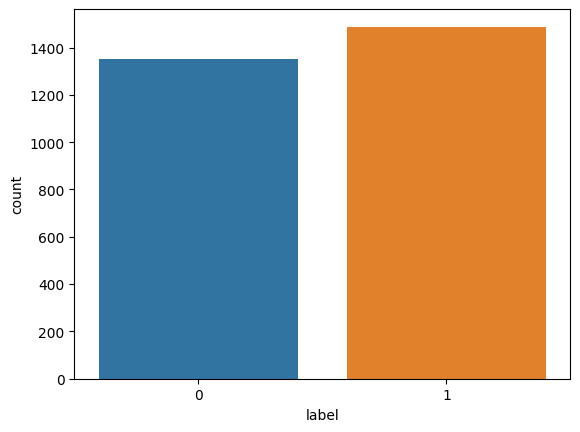

In [8]:
sns.countplot(x='label', data=df)

In [9]:
df['text'] = df['text'].apply(lambda x: x.lower())
df.sample(5)

,text,label
1190,"well, the warm season is here which means high...",1
1632,"i did a few emdr sessions, had great success, ...",1
2626,"i receive ssi/ssdi. about $1,000/mo. i have a ...",0
1487,"so, to start with i have ptsd from years of em...",1
1191,throwaway because i don't want this tied to my...,1


In [10]:
re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
df['text'] = df['text'].apply(lambda x: re_url.sub('', x))

re_letter = re.compile(r"[^a-z\s']")
df['text'] = df['text'].apply(lambda x: re_letter.sub('', x))
df.sample(10)

,text,label
1725,he has anger issues and he seems like a good g...,1
2809,after talking with my psych she made me realiz...,1
1889,there was not a single thing in my life i got ...,0
1081,i figured hey in this world of the internet th...,0
2255,so i guess i'll jump right in i have ptsd and ...,0
1494,i'm in desperate need for someone online to ju...,1
1446,link to donate url below you can find the miss...,0
1979,i had another friend come out and tap on my wi...,1
2198,rmadover is a sub for general discussion of me...,0
2304,back in november of my junior year of college...,0


In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

In [11]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('sentencizer')

In [12]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

df['text'] = df['text'].apply(remove_stopwords)
df.sample(10)

,text,label
274,years old suffered anxiety years anxiety stop ...,0
517,hey reddit ptsd independent documentary filmma...,0
938,haven't outgrown early s think there's possibl...,1
1170,need tips mental state avoidance tempted cbt l...,0
2641,yard talking phone refused hangup temper tantr...,1
240,don't want leave house know knows she's saying...,1
2277,feel like i'm end rope bawl night don't want f...,1
2379,let sucked incident occured threw fit arms leg...,1
1994,hey url driving fleetwood southwind rv madison...,0
703,hey cant lay like man tell wanted oversized kr...,0


In [13]:
df.drop_duplicates(subset='text', keep='first', inplace=True)

In [14]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

df['text'] = df['text'].progress_apply(lemmatize)
df.sample(10)

100%|██████████| 2818/2818 [00:34<00:00, 81.76it/s]


,text,label
554,student loan I m live miserable life I m work ...,1
185,hey time post live car brother cat feel extrem...,1
1974,come state time year dec ecstatic finally meet...,0
1780,mild dad hit butt love tap tell he d you ll un...,1
665,I be scared general living expectation partner...,1
1297,I be hope community share database useful poss...,0
1081,figure hey world internet bind video clip like...,0
534,thank submit request lot great request wish fu...,0
2410,try read plenty motivational quote day strengt...,0
1525,mind control do not feel try away like I m dru...,1


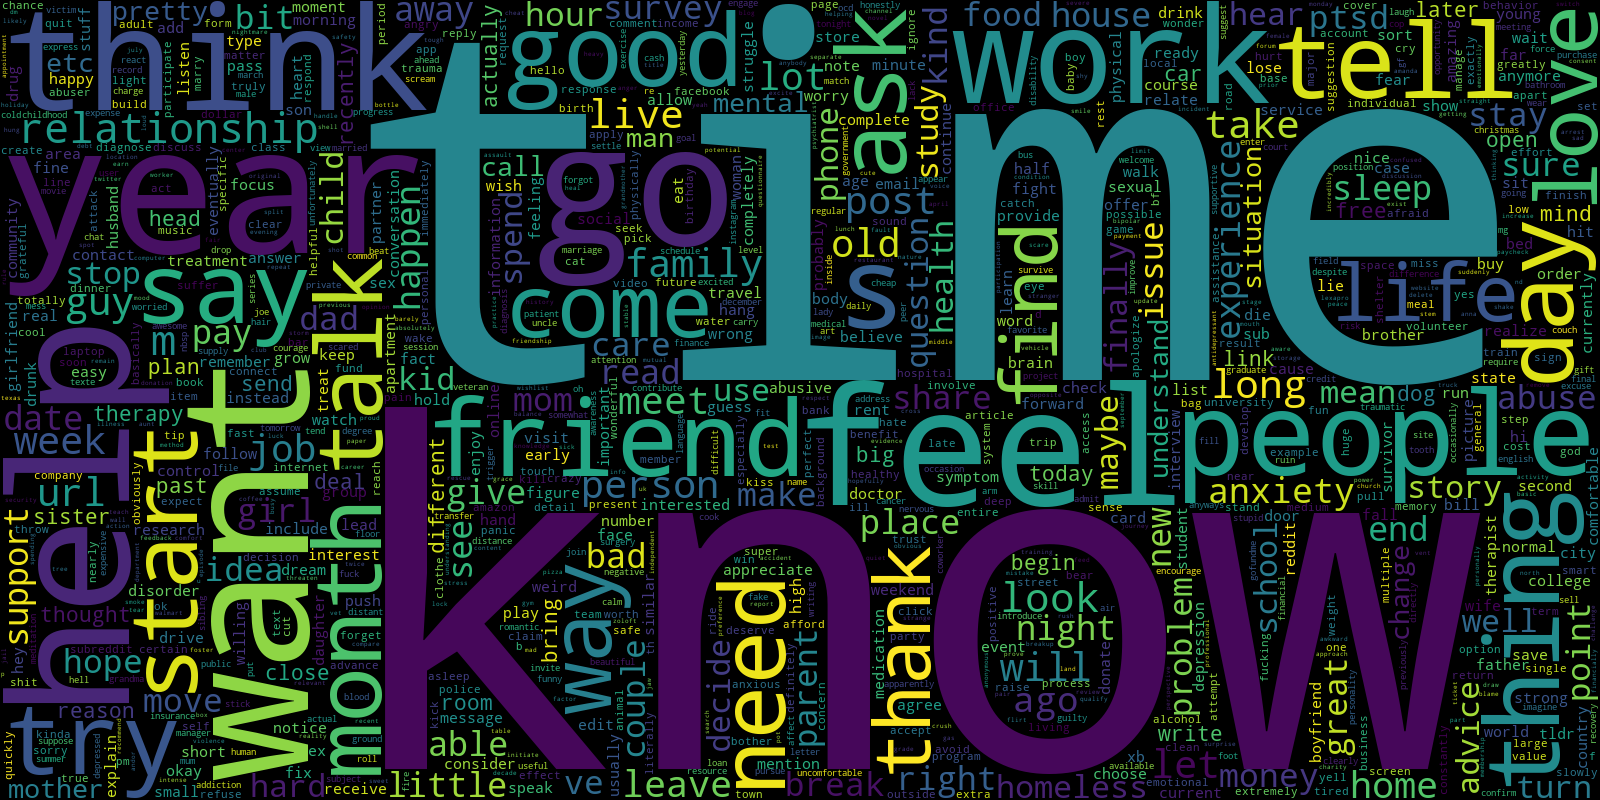

In [15]:
no_stress = ' '.join(df[df['label']==0]['text'])

wc_no_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(no_stress)
wc_no_stress.to_image()

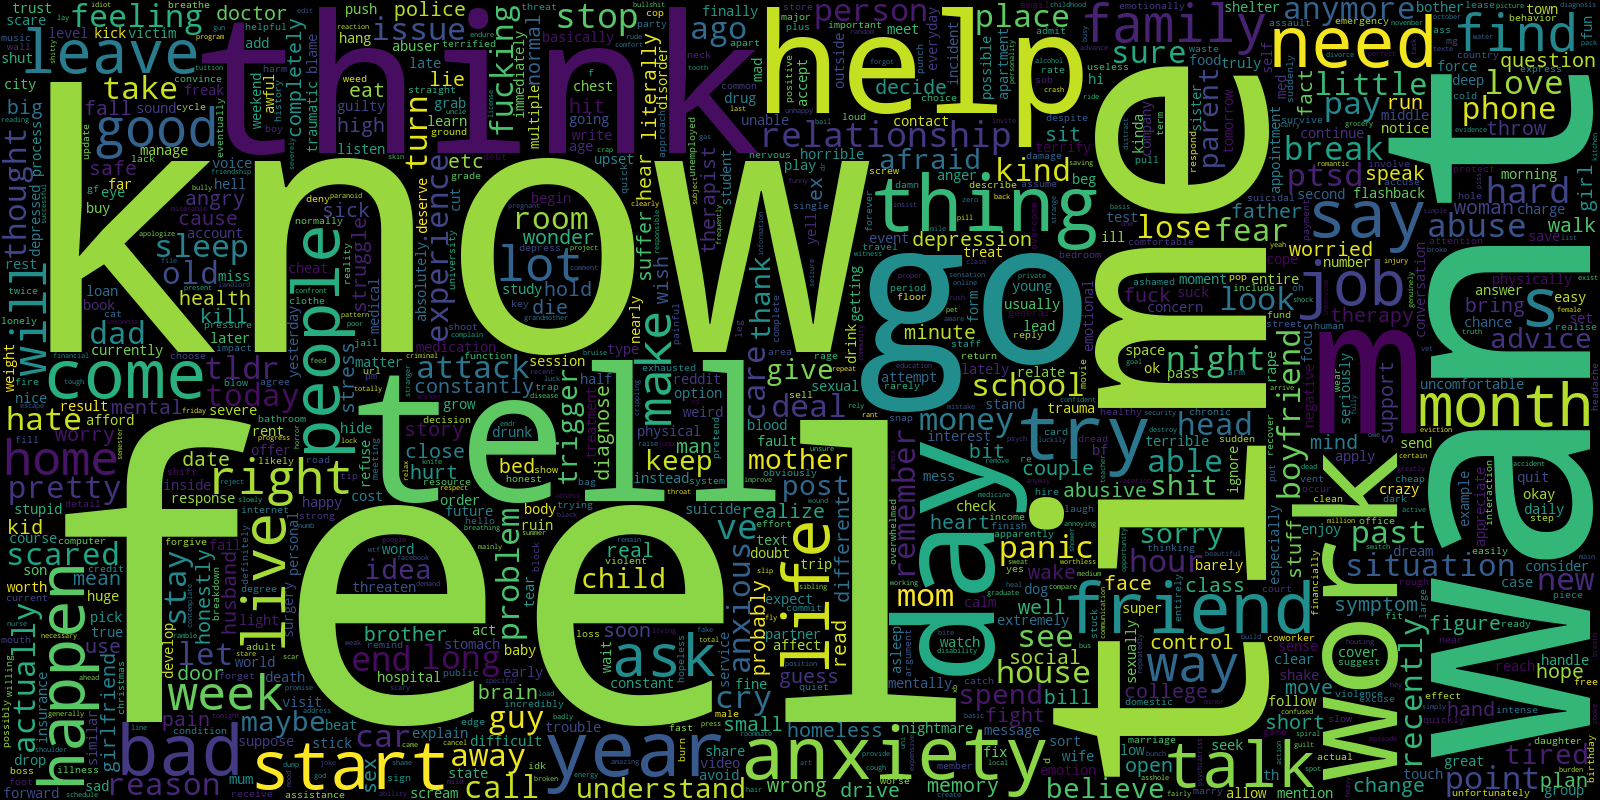

In [16]:
stress = ' '.join(df[df['label']==1]['text'])

wc_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(stress)
wc_stress.to_image()

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus,n,g):
  vec=CountVectorizer(ngram_range=(g,g)).fit(corpus)
  bag_of_words=vec.transform(corpus)
  sum_words=bag_of_words.sum(axis=0)
  words_freq=[(word,sum_words[0,idx]) for word ,idx in vec.vocabulary_.items()]
  words_freq=sorted(words_freq,key=lambda x:x[1],reverse=True)
  return words_freq[:n]

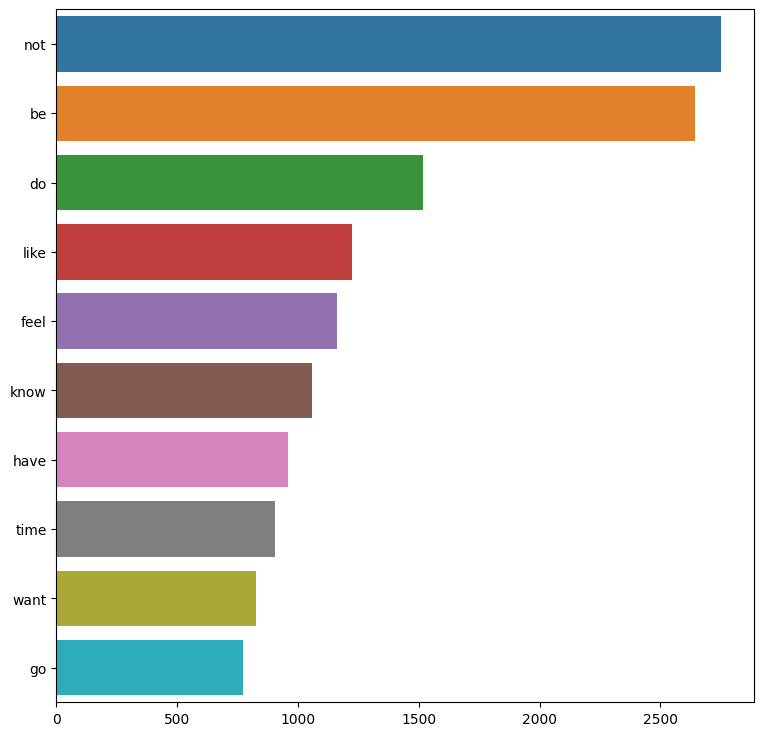

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 9))
most_common_uni = get_top_text_ngrams(df.text, 10, 1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()), y=list(most_common_uni.keys()))
plt.show()


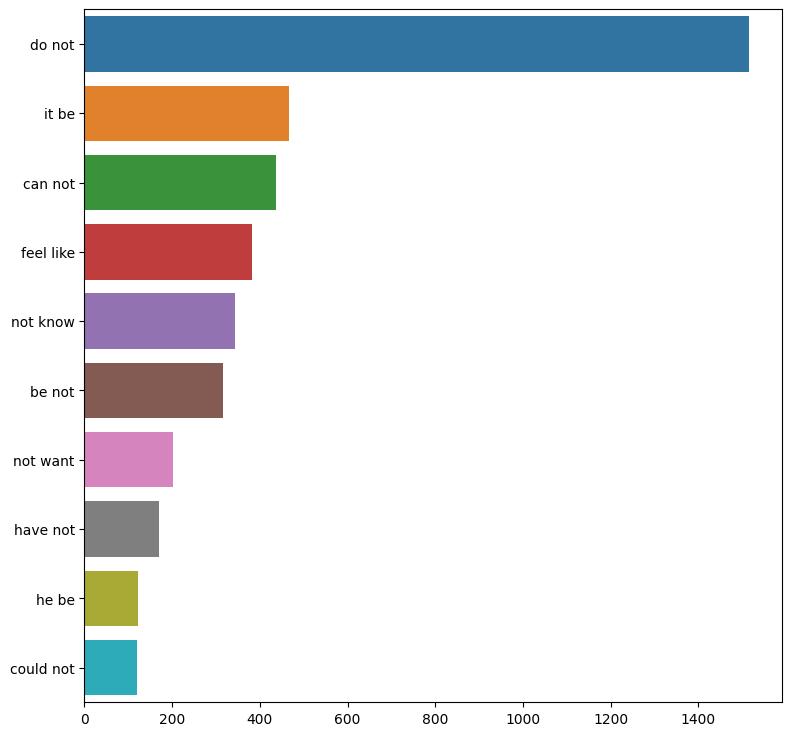

In [17]:
plt.figure(figsize=(9, 9))
most_common_uni = get_top_text_ngrams(df.text, 10, 2)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()), y=list(most_common_uni.keys()))
plt.show()

2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów <---
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

In [18]:
X_train,X_val,y_train,y_val=train_test_split(df.text,df.label,test_size=0.1,random_state=42)

In [19]:
X_train.shape,y_train.shape

((2536,), (2536,))

In [20]:
X_val.shape,y_val.shape

((282,), (282,))

In [21]:
max_features=1000
maxlen=300

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text

tokenizer=text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train=tokenizer.texts_to_sequences(X_train)
X_train=pad_sequences(tokenized_train,maxlen=maxlen)

In [23]:
type(X_train)

numpy.ndarray

In [24]:
X_val = [str(x) for x in X_val]

In [25]:
tokenized_test=tokenizer.texts_to_sequences(X_val)
X_val=pad_sequences(tokenized_test,maxlen=maxlen)

In [26]:
type(X_val)

numpy.ndarray

Podstawienie pre-trained word embeddingów

In [27]:
import gensim.downloader as api

word_vectors = api.load('word2vec-google-news-300')

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D

embedding_matrix = word_vectors.vectors

model_3 = Sequential()
model_3.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=maxlen, trainable=False)) 
model_3.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_3.add(Dense(1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          900000000 
                                                                 
 lstm_2 (LSTM)               (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 900,219,777
Trainable params: 219,777
Non-trainable params: 900,000,000
_________________________________________________________________
None


In [37]:
model_word2vec = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=6, batch_size=32)

Epoch 1/6
80/80 [==============================] - 108s 1s/step - loss: 0.6815 - accuracy: 0.5568 - val_loss: 0.6586 - val_accuracy: 0.6064
Epoch 2/6
80/80 [==============================] - 97s 1s/step - loss: 0.6351 - accuracy: 0.6372 - val_loss: 0.6372 - val_accuracy: 0.6596
Epoch 3/6
80/80 [==============================] - 112s 1s/step - loss: 0.6033 - accuracy: 0.6707 - val_loss: 0.6414 - val_accuracy: 0.6383
Epoch 4/6
80/80 [==============================] - 112s 1s/step - loss: 0.5897 - accuracy: 0.6861 - val_loss: 0.5945 - val_accuracy: 0.6879
Epoch 5/6
80/80 [==============================] - 110s 1s/step - loss: 0.5521 - accuracy: 0.7141 - val_loss: 0.5851 - val_accuracy: 0.6986
Epoch 6/6
80/80 [==============================] - 105s 1s/step - loss: 0.5467 - accuracy: 0.7275 - val_loss: 0.6119 - val_accuracy: 0.6950


In [38]:
print(" Accuracy on Val data: ",model_3.evaluate(X_val,y_val)[1] *100 ,"%")

9/9 [==============================] - 2s 192ms/step - loss: 0.6119 - accuracy: 0.6950
 Accuracy on Val data:  69.5035457611084 %


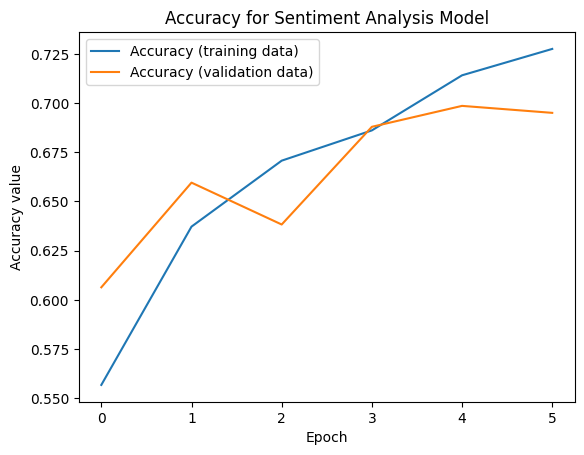

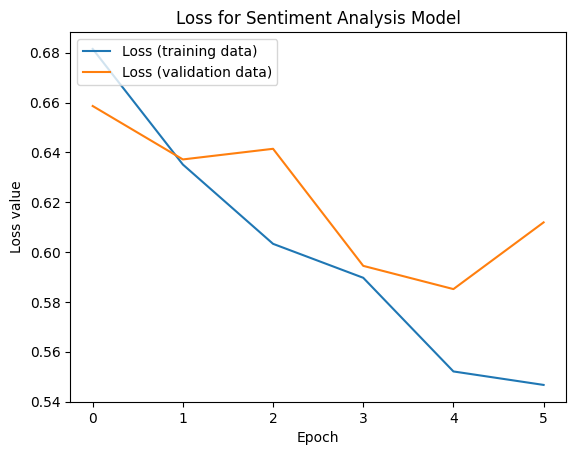

In [39]:
import matplotlib.pyplot as plt

plt.plot(model_word2vec.history['accuracy'], label='Accuracy (training data)')
plt.plot(model_word2vec.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Sentiment Analysis Model')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(model_word2vec.history['loss'], label='Loss (training data)')
plt.plot(model_word2vec.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Sentiment Analysis Model')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

In [40]:
def prepare_sentence(sentence):

    sentence = sentence.lower()

    re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
    sentence = re_url.sub('', sentence)

    re_letter = re.compile(r"[^a-z\s']")
    sentence = re_letter.sub('', sentence)

    def remove_stopwords(text):
        return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

    sentence = remove_stopwords(sentence)

    def lemmatize(text):
        return ' '.join([x.lemma_ for x in nlp(text)])

    sentence = lemmatize(sentence)

    tokenized_sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(tokenized_sentence, maxlen=maxlen, padding='post')

    return sentence

In [41]:
def predict_sentiment(model, sentence):
    
    prepared_sentence = prepare_sentence(sentence)
    prediction = model.predict(prepared_sentence)

    if prediction >= 0.5:
        return "I can sense STRESS in this sentence" 
    else:
        return "All good don't sense ANY STRESS in here "

Wykorzystanie sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN

In [42]:
sentence = "I had a peaceful evening reading my favorite book."
result = predict_sentiment(model_3, sentence)
print(result)

1/1 [==============================] - 0s 442ms/step
All good don't sense ANY STRESS in here 
